In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import uedge
from uedge import *
from uedge.hdf5 import *
import plotmesh as pm
from uetools import Case
from uedge.gridue import write_gridue
from Forthon import gchange

UEDGE configuration file /home/kasaiyuki/.uetoolsrc read.


# Notes
* plate1_vert_shortleg: (x,y) coordinates of plates

In [2]:
def setGrid(steps=4, plot=True):
    """ Generates a HDF5/ASCII grid

    Keyword arguments
    -----------------
    steps: int (default = 4)
        How far to progress in the grid generation progress
        =0 : Plot efit
        =1 : Plot flux surfaces
        =2 : Plot orthogonal grid
        =3 : Add plates to orthogonal grid
        =4 : Generate and plot grid with user plate shape
    plot : bool (default = True)
        Plot progress for each step if True
    """

    c=Case()
    # Set the geometry
    bbb.mhdgeo = 1 # =1 use MHD equilibrium files - include in input too
    com.geometry = 'dnbot' #  
    com.isudsym = 1 # up-down symmetric - include in input too

    # Set up EFIT equilibrium
    com.geqdskfname[0] = 'FDC24_TokaMaker_2024-09-25_v5_DB'
    com.aeqdskfname[0] = 'aeqdsk'

    '''
    com.geqdskfname[0] = 'MANTA_optimized__11122023'
    com.aeqdskfname[0] ='aeqdsk_orig'
    flx.ycutoff1 = 2.20 #1.50 #-2.3 #0.0 #1.50 # set lower cutoff on the eqdsk data
    '''
    if plot:
        c.grid.plot.efit(com.geqdskfname[0].decode('UTF-8'))

    """ FIRST, SET UP FLUX SURFACES """
    if steps>0:
        # Define flux contour boundaries
        flx.psi0min1 = 0.968 # normalized flux on core bndry
        flx.psi0min2 = 0.93 # normalized flux on pf bndry
        flx.psi0max_inner = 1.078 # Outboard side
        flx.psi0max_outer = 1.06 # Inboard side
        flx.psi0max = flx.psi0max_outer # Don't change this
        # !!! psi0sep HAD TO BE MODIFIED ACCORDING TO THE GEQDSK
        flx.psi0sep = 1.0101 # normalized flux at separatrix
        # Normally, this variable is just set to 1+1e-4 to capture
        # a flux surface just outside the separatrix. In this case,
        # it appears the geqdsk file throws off normalization. 
        # Not sure how serious it is, and it's best to wait until
        # the final equilibrium is agreed upon to investigate what
        # value is needed and how a large value impacts things.    

        # Define number of flux tubes
        com.nysol[0] = 27
        com.nyout[0] = 42 # Asymmetric dnull option, needed for plotting
                          # If error is thrown, modify accordingly
        com.nycore[0] = 17

        flx.alfcy = 2.1 # Radial flux-tube distribtuion: higher value, more 
                        # compressed around separatrix
        flx.altsearch = 1 # PFR search option, no touch

     
        flx.flxrun() # Generate flux surface based on the above
        if plot:
            f = c.grid.plot.flx()
            f.get_axes()[0].plot(com.rseps, com.zseps, 'ro')
            f.get_axes()[0].plot(com.rseps2, com.zseps2, 'go')
            f.get_axes()[0].plot(com.rvsin, com.zvsin, 'bo')
            f.get_axes()[0].plot(com.rvsout, com.zvsout, 'bo')


    """ SECOND, SET UP THE POLOIDAL ROWS """
    if steps>1:
        com.nxleg[0] = [16,24] # No cells in inner/outer leg
        com.nxcore[0] = [14,10] # No cells in inner/outer core region
        grd.kxmesh = 1 # Poloidal cell distribution model: =1 uses slpxt
        grd.slpxt = 1.2 # Cell compression factor at plates: higher values, more compressed
        com.ismmon=3 # Controls mesh generation
                      # =1: compressed distribution of mesh on each surface
                      # =2: standard distribution of mesh on each surface
                      # =3: linear combination of 1 & 2 determined by wtmesh1
        grd.wtmesh1=0.75 # =0 -> ismmon=2; =1 -> ismmon=1
        grd.dmix0=1.0 # Mixing length for upstream and downstream grid distros 
        grd.nsmooth=5 # Number of automated smoothing layers applied to mesh 
       

        grd.grdrun() # generate gridue file 
        write_gridue("gridue_orthogonal.hdf5") # Write HDF5 gridue
        c.reload() # Update Case arrays to reflect zshift
        if plot:
            f = c.plot.gridue('gridue_orthogonal.hdf5', plates=False)


    """ DISTORT MESH TO CONFORM TO PLATES """
    if steps>2:
        # !!! Replace below with your coding !!!
        import plates as pl
        # Store lengths of arrays
        grd.nplate1 = len(pl.rplate1)
        grd.nplate2 = len(pl.rplate2)
        gchange("Mmod") # Allocate space for arrays
        # Set plate specifying-points
        grd.rplate1 = pl.rplate1 
        grd.zplate1 = array(pl.zplate1) + com.zshift
        grd.rplate2 = pl.rplate2
        grd.zplate2 = array(pl.zplate2) + com.zshift
        # !!! Replace above with your coding !!!

        if plot:
            f.get_axes()[0].plot(grd.rplate1, grd.zplate1, 'r-')
            f.get_axes()[0].plot(grd.rplate2, grd.zplate2, 'b-')

    if steps>3:
        grd.iplate=1 # Use user-defined plate geometry in (r/z)plate(1/2)
        # Set up a strike-point search
        grd.isspnew = 1
        grd.isztest = 0
        grd.rstrike = [2.11, 2.42] #""" !!! Change !!! """
        # Ensure the rstrike is as close to the plate-intersect with the grid in the previous plot

        grd.grdrun() # generate gridue file 
        write_gridue("gridue_shaped.hdf5") # Write HDF5 gridue

        if plot:
            f = c.plot.gridue('gridue_shaped.hdf5', plates=False)
            f.get_axes()[0].plot(grd.rplate1, grd.zplate1, 'r-')
            f.get_axes()[0].plot(grd.rplate2, grd.zplate2, 'b-')

        c.populate() # Populate all UEDGE arrays to allow subsequent evaluations
                     # Note that plots may not work for subsequent executions



def setBoundaryConditions():
    global bbb

    # Boundary conditions
    bbb.isnicore[0] = 1	#=1 gives fixed uniform density ncore; =0 gives fixed particle flux
    bbb.ncore[0] = 1.5e20	#ion density on core if isnicore=1

    bbb.istewc = 2		#linear radial extrapolation condition for Te on outer wall
    bbb.istiwc = 2		#linear radial extrapolation condition for Ti outer wall
    bbb.isnwcono = 2		#linear radial extrapolation condition for ni on outer wall
    
    bbb.isnwconi = 1		##fixed ni=nwalli on PFR wall
    bbb.nwalli = 1e18
    bbb.istepfc = 1		#linear radial extrapolation condition for Te on PFR wall
    bbb.istipfc = 1		#linear radial extrapolation condition for Ti on PFR wall
	
    bbb.isupcore = 1		#=1 sets d(up)/dy=0

    bbb.iflcore = 1		#flag; =0, fixed Te,i; =1, fixed ion,elec core power
    bbb.pcoree = 6.5e6		#core elec power if iflcore=1
    bbb.pcorei = 6.5e6		#core ion power if iflcore=1

    bbb.recycp[0] = 1.0	#hydrogen recycling coeff at plates
    bbb.recycw[0] = 1.0	#hydrogen recycling coeff at wall boundaries
    
    bbb.bcee = 4.0		#target plate electron sheath coefficient
    bbb.bcei = 2.5		#target plate ion sheath coefficient

    bbb.istgwc = 0
    bbb.istgpfc = 0


def setSolver(experimental=False):
    global bbb
    # Solver package
    bbb.svrpkg = 'nksol'	#Newton solver using Krylov method
    bbb.premeth = 'ilut'	#Solution method for precond Jac'n matrix
    bbb.mfnksol = -3		# =3 for restricted increase in fnrm
    bbb.lfililut = 200
    bbb.lenplufac = 300	
    bbb.lenpfac = 200
    bbb.rlx = 0.1
    #del = 1.e-7
    bbb.epscon1 = 3e-3		#linear solver convergence
    bbb.n0g[0] = 1e18

    # Finite-difference algorithms (upwind, central diff, etc.)
    bbb.methn = 33 # ion continuity eqn
    bbb.methu = 33 # ion parallel momentum eqn
    bbb.methe = 33 # electron energy eqn
    bbb.methi = 33 # ion energy eqn
    bbb.methg = 66 # neutral gas continuity eqn


def setPhysics(impFrac=0.0):
    global bbb, com, aph

    # Ion Mass
    bbb.minu[0:2]=2.5		#D-T plasma

    # Flux limits
    bbb.isflxlde = 1
    bbb.isflxldi = 2
    bbb.flalfe = 10		#electron parallel thermal conduct. coeff
    bbb.flalfi = 10		#ion parallel thermal conduct. coeff
    bbb.flalfv = 0.5		#ion parallel viscosity coeff
    bbb.flgamv = 1.
    bbb.flalfgx = 1.		#neut. gas in poloidal direction
    bbb.flalfgy = 1.		#neut. gas in radial direction
    bbb.flalftgx = 1.		#neut power in poloidal direction
    bbb.flalftgy = 1.		#neut power in radial direction
    bbb.lgmax = 0.05		#max scale for gas particle diffusion
    bbb.lgtmax = 0.05		#max scale for gas thermal diffusion


    # Atomic Physics
    com.istabon = 10		#Stotler tables
    bbb.isrecmon = 1		#=1 for recombination
    aph.aphdir='aph/'

    ### source number 1:
    bbb.jxsoro[0] = 1		# this wall source starts in mesh region 1
    bbb.jxsori[0] = 1		# this pf source starts in mesh region 1
    bbb.matwso[0] = 1.
    bbb.matwsi[0] = 1.
    bbb.wgaso[0] = 1e3
    bbb.wgasi[0] = 1e3
    

    # Neutrals
    bbb.ineudif=2		
    bbb.cngfx=0.		#only effective when ineudif=1
    bbb.cngfy=0.		#only effective when ineudif=1
    bbb.cngflox=0.	#default#flux from convection
    bbb.cngfloy=0.	#default#flux from convection
    bbb.ngbackg=1e10

    # Inertial neutrals
    com.nhsp=2
    bbb.ziin[1]=0.
    bbb.isngon[0]=0
    bbb.isupgon[0]=1
    bbb.cngmom=0
    bbb.cmwall=0
    bbb.cngtgx=0
    bbb.cngtgy=0
    bbb.cfbgt=0
    bbb.kxn=0
    bbb.kyn=0
    bbb.recycm = -0.95	#latest recommmendation

    bbb.allocate()
    bbb.nphygeo()

    # Impurities
    if (impFrac>1e-8):
        bbb.isimpon = 2
        bbb.afracs = impFrac
        bbb.allocate()
    else:
        bbb.isimpon = 0


    bbb.kxe=1.0 #-parallel conduction factor                                                    
    bbb.islnlamcon=1 	#-Coulomb log                                                              
    bbb.lnlam=12
    bbb.isplflxlv=1 #=0, flalfv not active at ix=0 & nx;=1 active all ix                         
    bbb.isplflxlgx=1
    bbb.isplflxlgxy=1
    bbb.isplflxlvgx=1
    bbb.isplflxlvgxy=1
    bbb.iswflxlvgy=1
    bbb.isplflxltgx=1
    bbb.isplflxltgxy=1
    bbb.iswflxltgy=1 #-the main one, the only one that really matters                            
    bbb.isplflxl=1   # =0, flalfe,i not active at ix=0 & nx;=1 active all ix                     
    bbb.iswflxlvgy=1 # integer /1/ #=0, flalfvgy not active at iy=0 & ny;=1 active all iy        
    bbb.cngflox=1    # real /ngspmx*1./ #fac for x-flux from convection in ng-eqn.               
    bbb.isupwi=1     # integer /nispmx*1/ #=2 sets dup/dy=0 on inner wall                        
    bbb.isupwo=1     # integer /nispmx*1/ #=2 sets dup/dy=0 on outer wall
    
    
    #Divertor pumping
    bbb.nwsor = 2	#Add +1 new wall source
    
    bbb.issorlb[1]=0	#Set xgasi as distance from outer target
    bbb.xgasi[1]=0.1	#Set source location on ny=0 boundary (PFR)
    bbb.wgasi[1]=0.2	#Set width of source(/sink) region
    
    bbb.albdsi[1]=1.0 #0.9997 #1.0 #0.999 #Set neutral albedo for PFR source
    bbb.igasi[1]=-820
    
  


def setDChi(DOutFactor=1, DInFactor=1, chiInb=0.1, convec=False):
    """
    Arguments
        chiInb: constant chi on inboard side, increasing it decreases P_inner_xpt
        convec: set radial v_conv on outboard side
    """
    # Transport coefficients (m**2/s) 
    bbb.travis[0] = 1.0 # eta_a for radial ion momentum diffusion
    bbb.difutm = 0.50 # toroidal diffusivity for potential
    bbb.difni[0] = 0#0.025		#D for radial hydrogen diffusion
    bbb.kye = 0.#0.0075		#chi_e for radial elec energy diffusion
    bbb.kyi = 0.#0.0075		#chi_i for radial ion energy diffusion
    bbb.isbohmcalc = 0
    bbb.facbee = 1.0 # factor for Bohm Te diffusion coeff
    bbb.facbei = 1.0 # factor for Bohm Ti diffusion coeff
    bbb.facbni = 1.0 # factor for Bohm ni diffusion coeff
    bbb.nphygeo() # calculate radial coords of grid centers, yyc
    
    xoutboard = slice(bbb.ixmp, com.ixpt2[0]+1)
    xinboard = slice(0, bbb.ixmp)
    xoleg = slice(com.ixpt2[0]+1, com.nx+2)
    xileg = slice(0, com.ixpt1[0]+1)
    ycore = slice(0, com.iysptrx+2)
    ysol = slice(com.iysptrx, com.ny+2)

    # Profile of D on outboard side
#    DOut = 0.08*exp(com.yyc/2e-1)
#    DOut[0:com.iysptrx+1] = 0.08

    DOut = 0.026
    DInb = 0.026
    Dpfr = 0.10

    # Set D
    bbb.dif_use[xoutboard,:,0] = bbb.dif_use[xoleg,:,0] = DOut #DOut*DOutFactor 
    bbb.dif_use[xinboard,:,0]  = bbb.dif_use[xileg,:,0] = DInb #0.1*DInFactor 

    # set larger D in PFR
    bbb.dif_use[xoleg,ycore,0] = bbb.dif_use[xileg,ycore,0] = Dpfr
    

    # Profile of chi on outboard side
    #chimax = 0.1
    #reldepth = 0.12 # deepest point in well is chimax*(1-reldepth)

    #chiOut = chimax*((0.*com.yyc+1.) - reldepth*exp(-(com.yyc/1e-3)**2))

    chiOut = 0.015
    chiInb = 0.004 #0.0008
    chiInbpfr = 0.004 #0.003
    # Set chi
    bbb.kye_use[xoutboard,:] = bbb.kyi_use[xoutboard,:] = chiOut
    bbb.kye_use[xinboard,:]  = bbb.kyi_use[xinboard,:]  = chiInb 
    bbb.kye_use[xoleg,:]     = bbb.kyi_use[xoleg,:]     = chiOut
    bbb.kye_use[xileg,:]     = bbb.kyi_use[xileg,:]     = chiInb
   
    # also set larger chi in PFR (on inboard side)
    bbb.kye_use[xileg,ycore] = bbb.kyi_use[xileg,ycore] = chiInbpfr
 
    #if convec:
        #-set radial velocity in outermost radial layer
        #bbb.dif_use[: ,com.ny-1:com.ny+2, 0]=0.0
        #bbb.vy_use[:, com.ny-1:com.ny+2, 0]=1e2
        
        #-set radial velocity on PF boundary, inner leg
        #bbb.dif_use[0:com.ixpt1[0]+1, 0:3, 0]=0.0
        #bbb.vy_use[0:com.ixpt1[0]+1, 0:3, 0]=-1e2
        #
        #-set radial velocity on PF boundary, outer leg
        #bbb.dif_use[com.ixpt2[0]+1:com.nx+2, 0:3, 0]=0.0
        #bbb.vy_use[com.ixpt2[0]+1:com.nx+2, 0:3, 0]=-1e2 
        
    
def setup(impFrac=0.0, experimental=False, convec=False, plot_true=True):
    setGrid(plot=plot_true)
    setBoundaryConditions()
    setSolver(experimental=experimental)
    setPhysics(impFrac=impFrac)
    setDChi(convec=convec)
                   
       
    
    
def restore(name='uerun'):
    global bbb
    h5file = name + '.h5'
    if os.path.isfile(h5file):
        bbb.label[0] = name 
        bbb.restart = 1
        hdf5_restore(name + '.h5')
        bbb.dtreal = 1e-2
        bbb.exmain() 
    else:
        raise OSError(2, 'No such file', h5file)          
    


 
***  alfcy_inner has been re-defined  ***
 
 
     alfcy_inner =   2.619137E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:  TokaMaker:                                                  

 Wrote grid file successfully:
     file name:   gridue_orthogonal.hdf5
     run-ID:      TokaMaker:
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:  TokaMaker:                                                  

 Wrote grid file successfully:
     file name:   gridue_shaped.hdf5
     run-ID:      TokaMaker:
***********************************************
** CAUTION: NOT USING METHG=66 FOR ISNONOG=1 **
***********************************************
 
***  alfcy_inner has been re-defined  ***
 
 
     alfcy_inner =   2.619137E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:  TokaMaker:                                                  


*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without precon

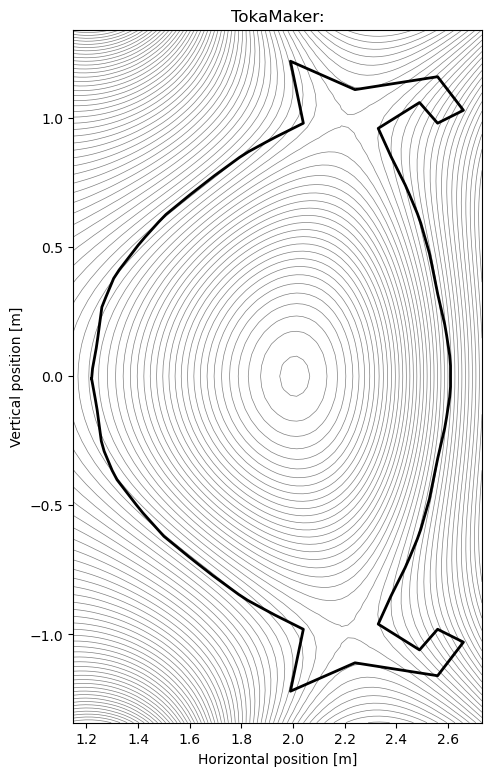

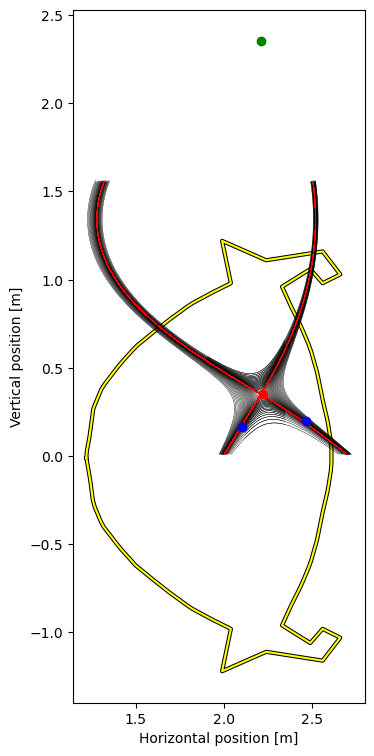

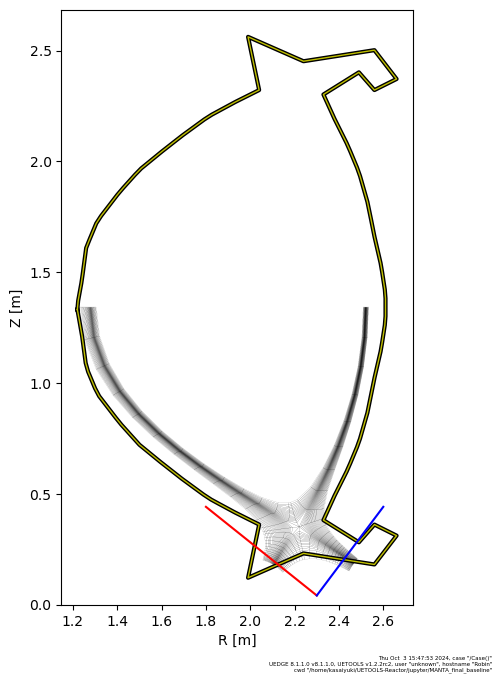

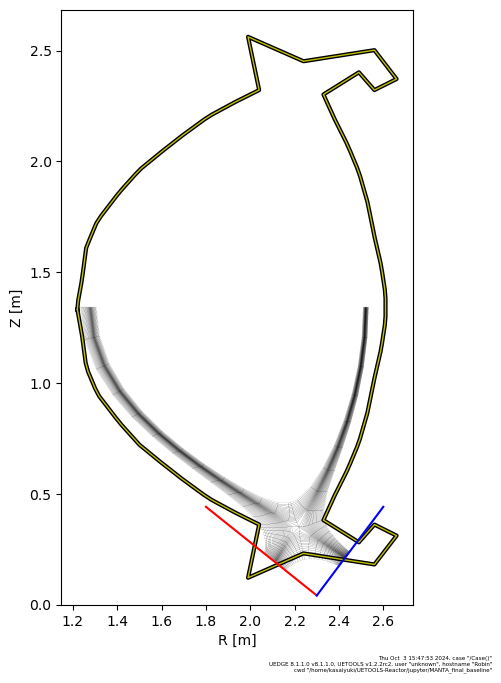

In [3]:
#Running UEdge 
setup(impFrac=3e-3, experimental=False,convec=False, plot_true=True)

restore('base_ITback_chi15e2_4e3pfr_D26_P26_imp3e3')

In [ ]:
c.grid.plot.efit("FDC24_TokaMaker_2024-09-25_v4_FS")

1.2.2rc2


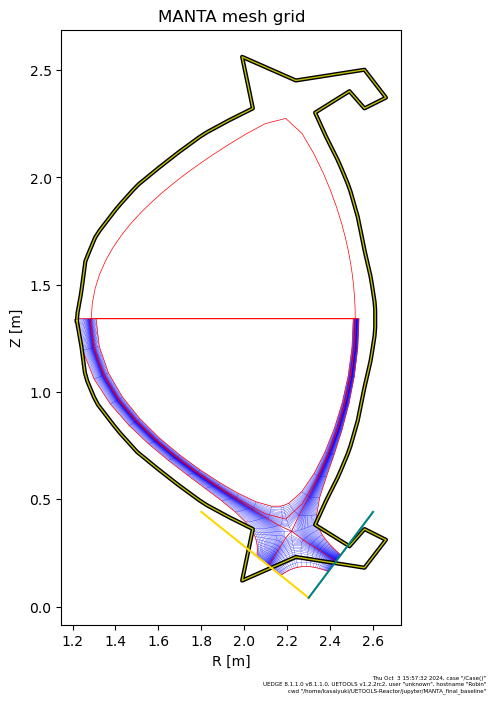

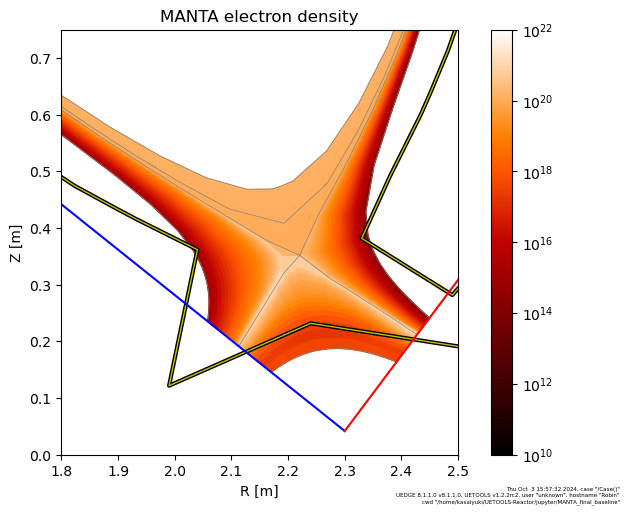

In [6]:
# UETOOLS Start
import uetools
print(uetools.__version__)
c = uetools.Case()
#c.plot.ne2d()
#bbb.exmain()
c.plot.grid(linewidth=0.1, #grid plot
       vessel=True, 
       plates=True, 
       platecolor=['gold','teal'], 
       lcfs=True, 
       lcfscolor='r', 
       linecolor='b',
       title='MANTA mesh grid'
      );

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.5), 
    ylim=(0,0.75), 
    figsize=(7,5), 
    zrange=(1e10,1e22), 
    cmap='gist_heat',
    title='MANTA electron density'
);
